In [1]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head(), test_data.head()


(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

Using device: cuda


Map:  52%|█████▏    | 4998/9601 [01:32<00:37, 124.07 examples/s]c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Map: 100%|██████████| 9601/9601 [02:27<00:00, 65.01 examples/s] 
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` envir

{'eval_loss': 0.19436392188072205, 'eval_accuracy': 0.9290698885532757, 'eval_runtime': 77.3951, 'eval_samples_per_second': 124.052, 'eval_steps_per_second': 7.765, 'epoch': 1.0}
{'loss': 0.2741, 'grad_norm': 0.6689556241035461, 'learning_rate': 3.3377703826955074e-05, 'epoch': 1.6638935108153077}
{'eval_loss': 0.0720861479640007, 'eval_accuracy': 0.9740652015415061, 'eval_runtime': 78.1664, 'eval_samples_per_second': 122.828, 'eval_steps_per_second': 7.689, 'epoch': 2.0}
{'eval_loss': 0.0340009480714798, 'eval_accuracy': 0.9880220810332258, 'eval_runtime': 96.8556, 'eval_samples_per_second': 99.127, 'eval_steps_per_second': 6.205, 'epoch': 3.0}
{'loss': 0.0868, 'grad_norm': 0.028689119964838028, 'learning_rate': 1.6738768718801997e-05, 'epoch': 3.327787021630616}
{'eval_loss': 0.02207615040242672, 'eval_accuracy': 0.993229871888345, 'eval_runtime': 77.5448, 'eval_samples_per_second': 123.812, 'eval_steps_per_second': 7.75, 'epoch': 4.0}
{'loss': 0.0279, 'grad_norm': 0.0439474806189537

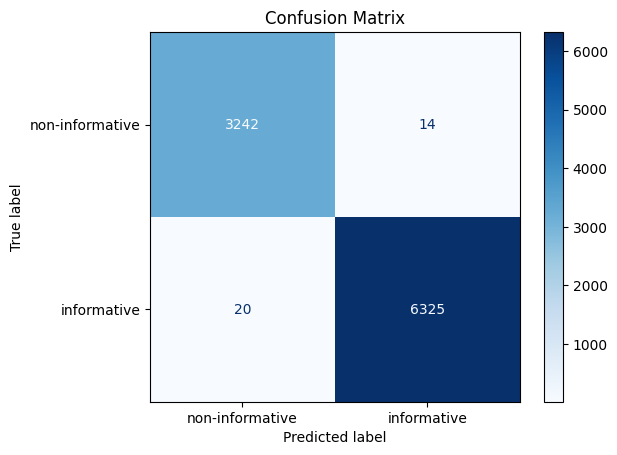

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import Dataset
from PIL import Image
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess the dataset
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
train_data = pd.read_csv(train_file_path, sep='\t')

# Filter data where label_text_image is "Positive"
filtered_data = train_data[train_data["label_text_image"] == "Positive"].reset_index(drop=True)

# Define the image processor
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Preprocessing function for dataset
def preprocess_data(example):
    try:
        # Load the image
        image = Image.open(example["image"])
        
        # Ensure all images are converted to RGB mode
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Process the image
        example["pixel_values"] = image_processor(image, return_tensors="pt")["pixel_values"][0]
    except Exception as e:
        print(f"Error loading image {example['image']}: {e}")
        # Replace invalid images with a dummy tensor
        example["pixel_values"] = torch.zeros((3, 224, 224))  # Dummy tensor for faulty images
    
    # Convert labels to numerical
    example["label"] = 1 if example["label_image"] == "informative" else 0
    return example

# Create a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(filtered_data)
hf_dataset = hf_dataset.map(preprocess_data)

# Move the dataset to the GPU for faster processing
hf_dataset.set_format(type="torch", columns=["pixel_values", "label"])

# Define the model
modelimage = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", 
    num_labels=2, 
    id2label={0: "non-informative", 1: "informative"}, 
    label2id={"non-informative": 0, "informative": 1}
).to(device)  # Move model to GPU

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./modelimage",  # Output directory
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save the model after each epoch
    logging_dir="./logs",  # Logging directory
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=1000,  # Log every 1000 steps instead of 10
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed-precision training (if available)
    disable_tqdm=True,  # Disable the tqdm progress bar here
)

# Define compute_metrics function
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Create Trainer
trainer = Trainer(
    model=modelimage,
    args=training_args,
    train_dataset=hf_dataset,
    eval_dataset=hf_dataset,  # Using the same dataset for evaluation
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
predictions = trainer.predict(hf_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Accuracy
accuracy = accuracy_score(labels, preds)
print(f"Training Accuracy: {accuracy:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(labels, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["non-informative", "informative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [4]:
# Specify the directory to save the model
save_directory = "D:/BTP_2/CrisisMMD_v2.0/model_image"

# Save the model
modelimage.save_pretrained(save_directory)

# Save the image processor
image_processor.save_pretrained(save_directory)

print(f"Model and image processor saved to {save_directory}")

Model and image processor saved to D:/BTP_2/CrisisMMD_v2.0/model_image
